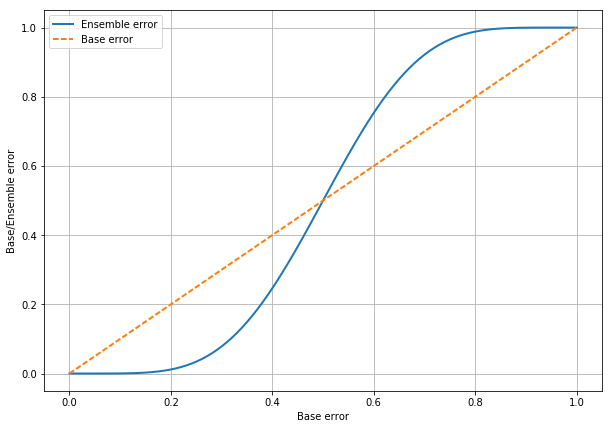

In [1]:
# error of an ensemble of classifiers
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier = 11, error = error) for error in error_range]

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 7))

plt.plot(error_range, ens_errors, label = 'Ensemble error', lw = 2)
plt.plot(error_range, error_range, linestyle = '--', label = 'Base error', lw = 2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1)

In [3]:
# initialize classifiers
from majority_vote_classifier import MajorityVoteClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

lr = LogisticRegression(penalty = 'l2', C = 0.01, random_state = 0)
dt = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)
knn = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

lr_pipe = Pipeline([['sc', StandardScaler()],
                  ['clf', lr]])
knn_pipe = Pipeline([['sc', StandardScaler()],
                  ['clf', knn]])

mvc = MajorityVoteClassifier(classifiers = [lr_pipe, dt, knn_pipe])

all_clf = [lr_pipe, dt, knn_pipe, mvc]
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'Majority Voting']
cv = 10
print('%d-fold cross validation:\n' % cv)
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = cv, scoring = 'roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


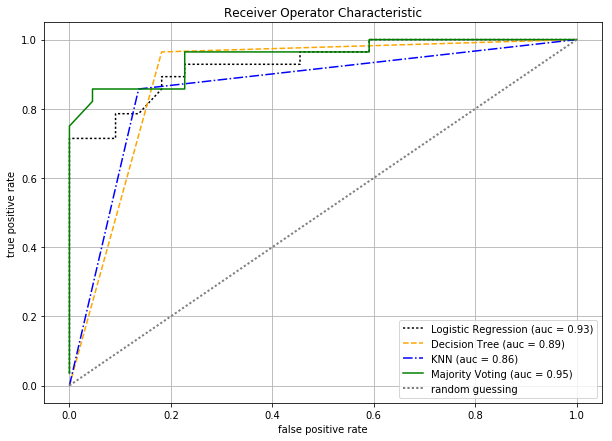

In [4]:
from sklearn.metrics import roc_curve, auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr, tpr, color = clr, ls = ls, label = '%s (auc = %0.2f)' % (label, roc_auc))
plt.plot([0, 1], [0, 1], ls = ':', color = 'gray', lw = 2, label = 'random guessing')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

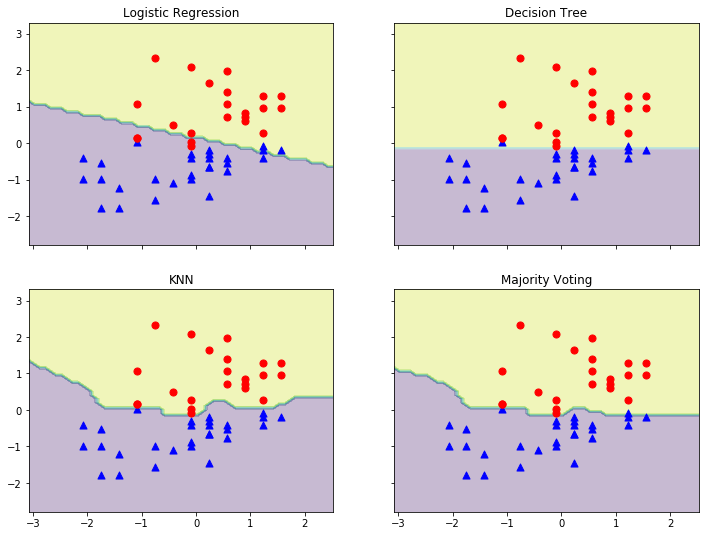

In [5]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 2, ncols = 2, sharex = 'col', sharey = 'row', figsize = (12, 9))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0], X_train_std[y_train == 0, 1], c = 'blue', marker = '^', s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0], X_train_std[y_train == 1, 1], c = 'red', marker = 'o', s = 50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 1, 10, 100]}

gs = GridSearchCV(estimator = mvc, param_grid = params, cv = cv, scoring = 'roc_auc')
gs.fit(X_train, y_train)
for params, mean_score, scores in gs.grid_scores_:
    print('%0.3f+/-%0.2f %r' % (mean_score, scores.std() / 2, params))

0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 10}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 10}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}


/usr/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
# bagging
